In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

!pip install --q japanize_matplotlib
import japanize_matplotlib

%matplotlib inline
plt.style.use("ggplot")

! pip install --q plotly
import plotly.graph_objects as go
import plotly.express as px

from sklearn.metrics import mean_squared_error


from google.cloud import bigquery
# プロジェクトIDの指定
project_id = 'inunaki'
# authが終わっていたら普通にクライアント認証は通る
client = bigquery.Client(project=project_id)

import warnings
warnings.simplefilter('ignore')


ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/conda/etc/jupyter/nbconfig/notebook.d/jupyterlab-plotly.json'
Consider using the `--user` option or check the permissions.



In [2]:
# 処理が重いのでcsv化しておく（8月1日 ~ 8月27日の期間の結果のみ）
df_osirase = pd.read_csv("data/お知らせタップデータ.csv")
df_koukoku = pd.read_csv("data/広告タップデータ.csv")
df_sengen = pd.read_csv("data/クーポン宣言データ.csv")
df_c_view = pd.read_csv("data/クーポンリストビューデータ.csv")
df_c_view["user_id"] = df_c_view["user_id"].astype(str)
df_sengen["user_id"] = df_sengen["user_id"].astype(str)
# ホームのデータにはSU-PAY会員以外も入っているので注意が必要
df_home = pd.read_csv("data/ホームビューと来店.csv")
df_home = df_home[["salesday_ure","user_id_ure","raiten_flg","view_name"]]
df_home = df_home.dropna().sort_values("user_id_ure")
df_home["user_id_ure"] = df_home["user_id_ure"].astype(int)
df_home["user_id_ure"] = df_home["user_id_ure"].astype(str)

In [3]:
# # お知らせをタップ
# query = """
# DECLARE DAY_START STRING DEFAULT '20230801';
# DECLARE DAY_END STRING DEFAULT '20230827';
# SELECT sync_date, user_id, substr(values,instr(values,"title")+LENGTH("title")+3,instr(substr(values,instr(values,"title")+LENGTH("title")+3,999),",")-2)as result
# FROM `karte-data.karte_stream_d2f5a0270a8665d8c5658511756d347c.krt_pockyevent_v1_*`
# WHERE _TABLE_SUFFIX BETWEEN DAY_START AND DAY_END
# AND event_name = "tap_notice"
# """
# #データフレームに変換
# df_osirase = client.query(query).to_dataframe()
# # 日付を日本時間にする
# df_osirase["salesday"] = pd.to_datetime(df_osirase["sync_date"])
# df_osirase["salesday"] = df_osirase["salesday"].dt.tz_convert('Asia/Tokyo')
# df_osirase["salesday"] = df_osirase["salesday"].dt.strftime("%Y-%m-%d")
# df_osirase["salesday"] = pd.to_datetime(df_osirase["salesday"])

# df_osirase.to_csv("data/お知らせタップデータ.csv",index=False)

In [4]:
# # 広告viewをタップ
# query = """
# DECLARE DAY_START STRING DEFAULT '20230801';
# DECLARE DAY_END STRING DEFAULT '20230827';
# SELECT sync_date, user_id, substr(values,instr(values,"name")+LENGTH("name")+3,instr(substr(values,instr(values,"name")+LENGTH("name")+3,999),",")-2)as result
# FROM `karte-data.karte_stream_d2f5a0270a8665d8c5658511756d347c.krt_pockyevent_v1_*`
# WHERE _TABLE_SUFFIX BETWEEN DAY_START AND DAY_END
# AND event_name = "tap_advertisement"
# """
# #データフレームに変換
# df_koukoku = client.query(query).to_dataframe()
# # 日付を日本時間にする
# df_koukoku["salesday"] = pd.to_datetime(df_koukoku["sync_date"])
# df_koukoku["salesday"] = df_koukoku["salesday"].dt.tz_convert('Asia/Tokyo')
# df_koukoku["salesday"] = df_koukoku["salesday"].dt.strftime("%Y-%m-%d")
# df_koukoku["salesday"] = pd.to_datetime(df_koukoku["salesday"])

# df_koukoku.to_csv("data/広告タップデータ.csv",index=False)


In [5]:
# # 宣言した人数
# query = """
#   SELECT  DATE(year,month,dt) AS dt, month, customer_id, sync_dttm, coupon_name, CAST(coupon_id AS INT64) AS coupon_id, customercd
#   FROM `inunaki.dwd_action_0001.dwd_karte_user_use_coupon` use_coupon
#   LEFT JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5_cus
#   ON use_coupon.customer_id = md5_cus.customercd_md5
#   WHERE DATE(year,month,dt) BETWEEN "2023-08-01" AND "2023-08-27"
# """

# #データフレームに変換
# df_sengen = client.query(query).to_dataframe()
# df_sengen = df_sengen.query("coupon_name!='【テスト】ひんやり敷きパッド_S_約100×205cm'")

# df_sengen = df_sengen.rename(columns={"customercd":"user_id"})
# df_sengen.to_csv("data/クーポン宣言データ.csv",index=False)

In [6]:
# # クーポンリストを見た人
# query = """
# SELECT  DATE(year,month,dt) AS dt, month, customer_id, sync_dttm, view_name, customercd
# FROM `inunaki.dwd_action_0001.dwd_karte_user_view_couponlist` use_coupon
# LEFT JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5_cus
# ON use_coupon.customer_id = md5_cus.customercd_md5
# WHERE DATE(year,month,dt) BETWEEN "2023-08-01" AND "2023-08-27"
# """
# #データフレームに変換
# df_c_view = client.query(query).to_dataframe()

# df_c_view = df_c_view.rename(columns={"customercd":"user_id"})
# df_c_view.to_csv("data/クーポンリストビューデータ.csv",index=False)

In [7]:
# # # ホームを開いたデータと来店したデータの組み合わせ
# query = """
# -- 期間を絞る
# CREATE TEMPORARY FUNCTION to_date() AS (DATE(2023, 8, 27));
# CREATE TEMPORARY FUNCTION to_date_start_date() AS(DATE(2023, 8, 1));

# -- 実際に購入まで行った顧客
# WITH base AS(
#   SELECT  salesday, COALESCE(customercd_new, posid.customercd) AS customercd
#   FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_header` posid 
#   LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
#   ON posid.customercd = ii.customercd
#   WHERE salesday BETWEEN to_date_start_date() AND to_date() 
#   AND posid.customercd <> "0"
#   GROUP BY salesday, customercd
#  ),
#  base2 AS (
#  SELECT salesday, md5_cus.customercd AS user_id, base.customercd, 1 AS raiten_flg
#  FROM base
#  LEFT JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5_cus
#  ON base.customercd = md5_cus.customercd_md5
# ),
#  -- 期間中にホームを一度でも見た顧客
# home_view AS(
#   SELECT  DATE(year,month,dt) AS salesday, md5_cus.customercd AS user_id, home.customer_id, view_name
#   FROM `inunaki.dwd_action_0001.dwd_karte_supay_accesshome` home
#   LEFT JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5_cus
#   ON home.customer_id = md5_cus.customercd_md5
#   WHERE DATE(year,month,dt) BETWEEN to_date_start_date() AND to_date() 
# ),
# home_view2 AS(
#   SELECT salesday, user_id, customer_id, view_name
#   FROM home_view
#   GROUP BY salesday, user_id, customer_id, view_name
# )
# SELECT base2.salesday AS salesday_ure, home_view2.salesday AS salesday_app, base2.user_id AS user_id_ure,  home_view2.user_id AS  user_id_app,
#        COALESCE(raiten_flg, 0) AS raiten_flg, COALESCE(view_name, "no") AS view_name
# FROM base2
# FULL OUTER JOIN home_view2
# ON base2.salesday = home_view2.salesday
# AND base2.user_id = home_view2.user_id
# """
# df_home = client.query(query).to_dataframe()
# df_home["salesday_ure"] = df_home["salesday_ure"].fillna(df_home["salesday_app"])
# df_home["user_id_ure"] = df_home["user_id_ure"].fillna(df_home["user_id_app"])

# # df_home.to_csv("data/ホームビューと来店.csv",index=False)

In [8]:
query = """
-- 期間を絞る
CREATE TEMPORARY FUNCTION to_date() AS (DATE(2023, 8, 27));
CREATE TEMPORARY FUNCTION to_date_start_date() AS(DATE(2023, 8, 1));

-- 実際に購入まで行った顧客
WITH base AS(
  SELECT  salesday, salestime, COALESCE(customercd_new, posid.customercd) AS customercd
  FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_header` posid 
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
  ON posid.customercd = ii.customercd
  WHERE salesday BETWEEN to_date_start_date() AND to_date() 
  AND posid.customercd <> "0"
  GROUP BY salesday, salestime, customercd
 )
 SELECT salesday, salestime, md5_cus.customercd AS user_id, base.customercd, 1 AS raiten_flg
 FROM base
 LEFT JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5_cus
 ON base.customercd = md5_cus.customercd_md5
"""
df_sale = client.query(query).to_dataframe()

df_sale = df_sale.dropna()
df_sale["user_id"] = df_sale["user_id"].astype(int)
df_sale = df_sale.query("user_id>=2970000000000")

In [9]:
df_sale.head()

,salesday,salestime,user_id,customercd,raiten_flg
2,2023-08-01,2023-08-01 17:40:00,2970005876949,500e0964f57b4f88cc364f37649d615b,1
7,2023-08-01,2023-08-01 18:23:00,2970007681091,442dc054ee3ed7a507c0faf7ca39df54,1
9,2023-08-01,2023-08-01 11:19:00,2970001670558,b71d96780ba5888b62aa2092a502b89a,1
16,2023-08-01,2023-08-01 17:27:00,2970002387790,e9f66ad4e77136bad4350bb8aa6fb339,1
18,2023-08-01,2023-08-01 16:16:00,2970002930514,4782015d6b1d86fc265cb7286b379071,1


In [10]:
df_home.head()

,salesday_ure,user_id_ure,raiten_flg,view_name
6797636,2023-08-12,2900000089723,1,no
4529344,2023-08-09,2906800126156,1,no
2068934,2023-08-09,2960000000067,1,no
4235135,2023-08-05,2960000000135,1,no
8249844,2023-08-12,2960000000135,1,no


In [11]:
df_home["raiten_flg"].unique()

array([1, 0])

In [12]:
df_home.head()

,salesday_ure,user_id_ure,raiten_flg,view_name
6797636,2023-08-12,2900000089723,1,no
4529344,2023-08-09,2906800126156,1,no
2068934,2023-08-09,2960000000067,1,no
4235135,2023-08-05,2960000000135,1,no
8249844,2023-08-12,2960000000135,1,no


In [13]:
df_osirase.head()

,sync_date,user_id,result,salesday
0,2023-08-12 02:58:24.245000+00:00,2970000010034,銀行口座の更新期限切れについて,2023-08-12
1,2023-08-12 08:01:36.241000+00:00,2970008640370,Android端末の口座連携ができない事象について,2023-08-12
2,2023-08-12 02:21:24.849000+00:00,2970007088302,ポイント数「０」表示について,2023-08-12
3,2023-08-12 08:14:47.511000+00:00,2970002737014,200ポイントプレゼントキャンペーン,2023-08-12
4,2023-08-12 06:39:19.242000+00:00,2970000002220,銀行口座の更新期限切れについて,2023-08-12


In [14]:
df_koukoku.head()

,sync_date,user_id,result,salesday
0,2023-08-20 22:39:41.317000+00:00,2970004109277,TEST,2023-08-21
1,2023-08-20 22:39:41.317000+00:00,2970004109277,TEST,2023-08-21
2,2023-08-20 22:52:53.377000+00:00,2970004109277,TEST,2023-08-21
3,2023-08-20 22:26:24.447000+00:00,2970008218067,フリースアンバサダー募集,2023-08-21
4,2023-08-20 23:26:21.464000+00:00,2970008363101,フリースアンバサダー募集,2023-08-21


In [15]:
df_koukoku["result"].value_counts()

サマーキャンペーン詳細                                 95422
クーポンの利用方法                                   76878
2023_フォトコンテスト                               22753
トライアルマガジンカツ重                                 3245
トライアルマガジン阿蘇くじゅうの天然水                          2296
トライアルマガジン_レーズンブレッド                           1941
トライアル会員限定　虎の湯                                1770
トライアルマガジンバナナ                                 1698
お盆ごちそう_ネット                                   1430
トライアルマガジン猫缶                                  1399
お盆ごちそう_鮮魚のみ                                  1191
フリースアンバサダー募集                                  940
トライアルマガジン_3種のスイーツ                             639
お盆ごちそう_両方惣菜                                   442
お盆ごちそう_両方鮮魚                                   405
EC_炭酸水                                        259
アンケート                                         240
アイランドシティ店チラシ                                  182
お盆ごちそう_惣菜のみ                                    92
トライアルマガジン_ビール飲み比べ                              90


In [16]:
df_c_view.head()

,dt,month,customer_id,sync_dttm,view_name,user_id
0,2023-08-01,8,0b29c0281c69ec6a868dd234007d2727,2023-08-01 14:13:20.281,CouponList,2970002099129
1,2023-08-01,8,1e06d5b09789b18000c8d94ea3aa5f1f,2023-08-01 12:59:11.349,CouponList,2970000005856
2,2023-08-01,8,cb0c957ed1a00454720cff216af000cf,2023-08-01 16:50:24.647,CouponList,2970001055744
3,2023-08-01,8,721abcaa2a35fc7b24e86bdfb7c8778b,2023-08-01 16:03:13.369,CouponList,2970000474263
4,2023-08-01,8,b6a9e0053b1a2c4381ecd91a620b969a,2023-08-01 19:43:41.515,CouponList,2970003755369


In [17]:
# ホームを使って、来店しなかったID
df_home_nomi = df_home.query("raiten_flg==0&view_name=='Home'")[["user_id_ure"]].drop_duplicates()
df_home_nomi["来店なし"] = 1
# ホームを使って、来店したID
df_home_ari = df_home.query("raiten_flg==1&view_name=='Home'")[["user_id_ure"]].drop_duplicates()
df_home_ari["来店あり"] = 1
df_home_nomi = df_home_nomi.merge(df_home_ari,on="user_id_ure",how="outer").fillna(0)
df_home_nomi = df_home_nomi.query("来店なし==1&来店あり==0")
# 来店していないがアプリは開いているユーザー（アプリを開いた日に買い物をしているかどうかで判断する）
df_home_nomi = df_home_nomi[["user_id_ure"]].drop_duplicates()
df_home_nomi = df_home_nomi.rename(columns={"user_id_ure":"user_id"})
df_home_nomi["ホーム使い"] = 1

In [18]:
df_home_nomi.head()

,user_id,ホーム使い
0,2970000000301,1
3,2970000000387,1
6,2970000000431,1
9,2970000000462,1
10,2970000000479,1


In [19]:
# 来店した時に会員証として使っている顧客
df_kaiin_tmp = df_home.query("raiten_flg==1&view_name=='Home'")
df_kaiin_tmp = df_kaiin_tmp[["user_id_ure"]].drop_duplicates()
df_kaiin_tmp = df_kaiin_tmp.rename(columns={"user_id_ure":"user_id"})
df_kaiin_tmp["会員証使い"] = 1
# お知らせをタップした顧客
df_osirase_tmp = df_osirase[["user_id"]].drop_duplicates()
df_osirase_tmp["お知らせ使い"] = 1
# 広告をタップした顧客
df_koukoku_tmp = df_koukoku[["user_id"]].drop_duplicates()
df_koukoku_tmp["広告使い"] = 1
# クーポンを宣言した顧客
# df_sengen_tmp = df_sengen[["user_id"]].drop_duplicates()
# df_sengen_tmp["クーポン使い"] = 1

# クーポンを閲覧した顧客
df_c_view_tmp = df_c_view[["user_id"]].drop_duplicates()
df_c_view_tmp["クーポン使い"] = 1

df_result_tmp = df_home_nomi.merge(df_kaiin_tmp,on="user_id",how="outer").fillna(0)
df_result_tmp = df_result_tmp.merge(df_osirase_tmp, on="user_id",how="outer").fillna(0)
df_result_tmp = df_result_tmp.merge(df_koukoku_tmp, on="user_id",how="outer").fillna(0)
df_result_tmp = df_result_tmp.merge(df_c_view_tmp, on="user_id",how="outer").fillna(0)

# 会員IDが数字のものだけに絞る
df_result_tmp = df_result_tmp[df_result_tmp['user_id'].str.len() <= 13]

df_result = df_result_tmp.groupby(["ホーム使い","会員証使い","お知らせ使い","広告使い","クーポン使い"]).agg({"user_id":"count"}).reset_index().sort_values("user_id",ascending=False)
df_result = df_result.rename(columns={"user_id":"対象人数"})
df_result["比率"] = round(df_result["対象人数"] / df_result["対象人数"].sum() * 100, 2)
df_result["比率"] = df_result["比率"].astype(str) + "%"

In [20]:
df_result

,ホーム使い,会員証使い,お知らせ使い,広告使い,クーポン使い,対象人数,比率
5,0.0,1.0,0.0,0.0,0.0,159771,41.43%
6,0.0,1.0,0.0,0.0,1.0,43854,11.37%
8,0.0,1.0,0.0,1.0,1.0,38181,9.9%
13,1.0,0.0,0.0,0.0,0.0,35359,9.17%
7,0.0,1.0,0.0,1.0,0.0,30176,7.83%
12,0.0,1.0,1.0,1.0,1.0,21053,5.46%
9,0.0,1.0,1.0,0.0,0.0,13224,3.43%
14,1.0,0.0,0.0,0.0,1.0,9819,2.55%
10,0.0,1.0,1.0,0.0,1.0,9690,2.51%
11,0.0,1.0,1.0,1.0,0.0,8586,2.23%


In [21]:
df_zentai = df_result_tmp.drop("user_id",axis=1).sum().reset_index()
df_zentai[0] = df_zentai.apply(lambda x:len(df_result_tmp.query("ホーム使い==0&会員証使い==1&お知らせ使い==0&広告使い==0&クーポン使い==0")) if x["index"]=="会員証使い" else x[0],axis=1)
df_zentai[0] = df_zentai.apply(lambda x:len(df_result_tmp.query("ホーム使い==1&会員証使い==0&お知らせ使い==0&広告使い==0&クーポン使い==0")) if x["index"]=="ホーム使い" else x[0],axis=1)
df_zentai["期間中利用人数"] = df_result_tmp["user_id"].nunique()
df_zentai.columns = ["項目","利用人数","期間中利用人数"]
df_zentai["利用率"] = round(df_zentai["利用人数"] / df_zentai["期間中利用人数"] * 100, 2)
df_zentai = df_zentai.sort_values("利用率", ascending=False)
df_zentai["利用率"] = df_zentai["利用率"].astype(str) + "%"
df_zentai = df_zentai.replace("会員証使い", "会員証のみ").replace("ホーム使い", "ホームのみ")
df_zentai["利用人数"] = df_zentai["利用人数"].astype(int)

In [22]:
# 重複あり
df_zentai

,項目,利用人数,期間中利用人数,利用率
1,会員証のみ,159771,385601,41.43%
4,クーポン使い,131362,385601,34.07%
3,広告使い,110228,385601,28.59%
2,お知らせ使い,58356,385601,15.13%
0,ホームのみ,35359,385601,9.17%


In [23]:
# SU-PAYってどうやって使われている？


In [24]:
# 来店はしないけど見ている割合
df_osirase_tmp = df_osirase.groupby(["salesday","user_id"]).agg({"result":"count"}).reset_index().rename(columns={"result":"お知らせ閲覧数"})
df_koukoku_tmp = df_koukoku.groupby(["salesday","user_id"]).agg({"result":"count"}).reset_index().rename(columns={"result":"広告閲覧数"})
df_sengen_tmp = df_sengen.groupby(["dt","user_id"]).agg({"coupon_name":"count"}).reset_index().rename(columns={"coupon_name":"クーポン宣言数","dt":"salesday"})
df_c_view_tmp = df_c_view.groupby(["dt","user_id"]).agg({"view_name":"count"}).reset_index().rename(columns={"view_name":"クーポン閲覧数","dt":"salesday"})
df_home_tmp = df_home.query("view_name=='Home'").groupby(["salesday_ure","user_id_ure"]).agg({"view_name":"count"}).reset_index()\
.rename(columns={"view_name":"ホーム閲覧数","salesday_ure":"salesday","user_id_ure":"user_id"})
df_home_raiten_tmp = df_home.query("raiten_flg==1&view_name=='Home'").groupby(["salesday_ure","user_id_ure"]).agg({"view_name":"count"}).reset_index()\
.rename(columns={"view_name":"ホーム閲覧来店回数","salesday_ure":"salesday","user_id_ure":"user_id"})

# データをマージする
df_data = df_home_tmp.merge(df_home_raiten_tmp,on=["salesday","user_id"],how="outer").fillna(0)
df_data = df_data.merge(df_osirase_tmp, on=["salesday","user_id"],how="outer").fillna(0)
df_data = df_data.merge(df_koukoku_tmp, on=["salesday","user_id"],how="outer").fillna(0)
df_data = df_data.merge(df_c_view_tmp, on=["salesday","user_id"],how="outer").fillna(0)
# df_data = df_data.merge(df_sengen_tmp, on=["salesday","user_id"],how="outer").fillna(0)

In [25]:
df_data.head()

,salesday,user_id,ホーム閲覧数,ホーム閲覧来店回数,お知らせ閲覧数,広告閲覧数,クーポン閲覧数
0,2023-08-01,2970000000370,1.0,0.0,0.0,0.0,14.0
1,2023-08-01,2970000000431,1.0,0.0,0.0,0.0,0.0
2,2023-08-01,2970000000448,1.0,0.0,0.0,4.0,1.0
3,2023-08-01,2970000000493,1.0,1.0,0.0,0.0,1.0
4,2023-08-01,2970000000578,1.0,1.0,0.0,0.0,0.0


In [26]:
#来店していないが閲覧している割合（全体）
ratio = round(len(df_data.query("ホーム閲覧来店回数==0")) / len(df_data)*100,2)
print(f"来店していないが閲覧している割合（全体）：{ratio}％　")

来店していないが閲覧している割合（全体）：24.58％　


In [27]:
# # ホームは見たが来店していない顧客
# df_tmp = df_data.query("ホーム閲覧来店回数==0")
# for i in df_tmp[["お知らせ閲覧数","広告閲覧数","クーポン閲覧数","ホーム閲覧数","ホーム閲覧来店回数"]].columns:
#     df_tmp[i] = df_tmp.apply(lambda x:1 if x[i]>=1 else 0, axis=1)
# df_no_raiten_data = df_tmp.drop("user_id",axis=1).sum().reset_index().sort_values(0,ascending=False)
# df_no_raiten_data[0] = df_no_raiten_data[0].astype(int)
# df_no_raiten_data.columns = ["項目","利用数"]

# # 来店した顧客
# df_tmp = df_data.query("ホーム閲覧来店回数==1")
# for i in df_tmp[["お知らせ閲覧数","広告閲覧数","クーポン閲覧数","ホーム閲覧数","ホーム閲覧来店回数"]].columns:
#     df_tmp[i] = df_tmp.apply(lambda x:1 if x[i]>=1 else 0, axis=1)
# df_yes_raiten_data = df_tmp.drop("user_id",axis=1).sum().reset_index().sort_values(0,ascending=False)
# df_yes_raiten_data[0] = df_yes_raiten_data[0].astype(int)
# df_yes_raiten_data.columns = ["項目","利用数"]

# df_no_raiten_data["割合"] = round(df_no_raiten_data["利用数"] / len(df_data.query("ホーム閲覧来店回数==0"))*100, 2)
# df_no_raiten_data["割合"] = df_no_raiten_data["割合"].astype(str) + "%"
# df_yes_raiten_data["割合"] = round(df_yes_raiten_data["利用数"] / len(df_data.query("ホーム閲覧来店回数==1"))*100, 2)
# df_yes_raiten_data["割合"] = df_yes_raiten_data["割合"].astype(str) + "%"

In [28]:
# df_yes_raiten_data#.query("項目!='ホーム閲覧数'").query("項目!='ホーム閲覧来店回数'")

In [29]:
# df_no_raiten_data#.query("項目!='ホーム閲覧数'").query("項目!='ホーム閲覧来店回数'")

In [30]:
!pip install --q pywaffle
from pywaffle import Waffle

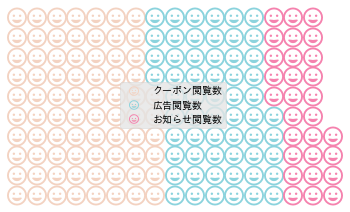

In [31]:
# data = {'クーポン閲覧数': 76036, '広告閲覧数': 59564, 'お知らせ閲覧数': 29130}
data = {'クーポン閲覧数': 76, '広告閲覧数': 59, 'お知らせ閲覧数': 29}
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=data,
    colors=["#f3d2c1", "#8bd3dd", "#f582ae"],
    legend={'loc': 'center'},
    icons='grin',
    icon_size=20,
    icon_style="regular",
    icon_legend=True,
    figsize=(5, 5)
)
plt.show()

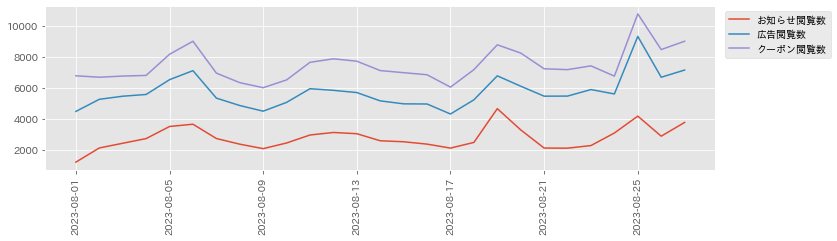

In [32]:
df_data["salesday"] = pd.to_datetime(df_data["salesday"])
df_tmp = df_data.copy()
for i in df_tmp[["お知らせ閲覧数","広告閲覧数","クーポン閲覧数","ホーム閲覧数","ホーム閲覧来店回数"]].columns:
    df_tmp[i] = df_tmp.apply(lambda x:1 if x[i]>=1 else 0, axis=1)

plot_tmp = df_tmp.query("salesday<=20230827").groupby(["salesday"]).sum()[["お知らせ閲覧数","広告閲覧数","クーポン閲覧数"]]
plot_tmp2 = df_tmp.query("salesday<=20230827").query("ホーム閲覧来店回数==1&お知らせ閲覧数==0&広告閲覧数==0&クーポン閲覧数==0").groupby(["salesday"]).sum()[["ホーム閲覧来店回数"]]
plt.figure(figsize=(12,3))
plt.plot(plot_tmp,label=plot_tmp.columns)
# plt.plot(plot_tmp2,label="ホームのみ")
plt.legend(loc="upper right", bbox_to_anchor=(1.18, 1))
plt.xticks(rotation=90)
plt.show()

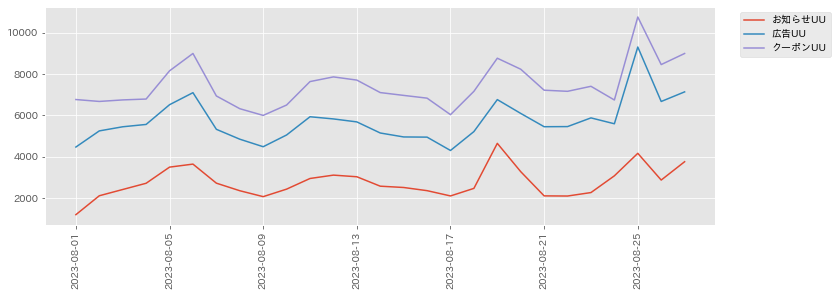

In [33]:
plot_tmp = plot_tmp.rename(columns={"お知らせ閲覧数":"お知らせUU","広告閲覧数":"広告UU","クーポン閲覧数":"クーポンUU"})
plt.figure(figsize=(12,4))
plt.plot(plot_tmp,label=plot_tmp.columns)
# plt.plot(plot_tmp2,label="ホームのみ")
plt.legend(loc="upper right", bbox_to_anchor=(1.18, 1))
plt.xticks(rotation=90)
plt.show()

In [34]:
plot_tmp.describe()

,お知らせUU,広告UU,クーポンUU
count,27.000000,27.000000,27.000000
mean,2767.074074,5720.296296,7439.481481
std,734.446622,1041.766208,1069.015556
min,1207.000000,4306.000000,5999.000000
25%,2318.500000,5102.000000,6756.000000
50%,2582.000000,5459.000000,7161.000000
75%,3099.000000,6014.500000,8004.000000
max,4650.000000,9301.000000,10750.000000


In [35]:
df_data.head()

,salesday,user_id,ホーム閲覧数,ホーム閲覧来店回数,お知らせ閲覧数,広告閲覧数,クーポン閲覧数
0,2023-08-01,2970000000370,1.0,0.0,0.0,0.0,14.0
1,2023-08-01,2970000000431,1.0,0.0,0.0,0.0,0.0
2,2023-08-01,2970000000448,1.0,0.0,0.0,4.0,1.0
3,2023-08-01,2970000000493,1.0,1.0,0.0,0.0,1.0
4,2023-08-01,2970000000578,1.0,1.0,0.0,0.0,0.0


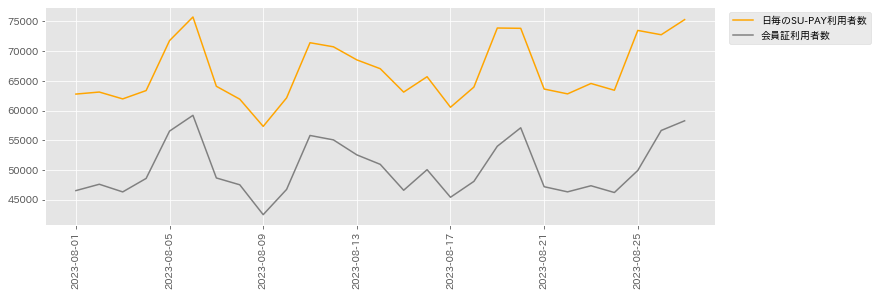

In [36]:
plot_tmp = df_data.query("salesday<=20230827").groupby(["salesday"]).agg({"user_id":"count","ホーム閲覧来店回数":"sum"}).reset_index()
plt.figure(figsize=(12,4))
plt.plot(plot_tmp["salesday"], plot_tmp["user_id"],label="日毎のSU-PAY利用者数", color="orange")
plt.plot(plot_tmp["salesday"], plot_tmp["ホーム閲覧来店回数"],label="会員証利用者数", color="gray")
plt.legend(loc="upper right", bbox_to_anchor=(1.24, 1))
plt.xticks(rotation=90)
plt.show()

In [37]:
plot_tmp.describe()

,user_id,ホーム閲覧来店回数
count,27.000000,27.000000
mean,66637.407407,50293.000000
std,5218.815879,4637.464543
min,57347.000000,42490.000000
25%,62968.000000,46669.500000
50%,64096.000000,48590.000000
75%,71603.000000,54540.500000
max,75758.000000,59208.000000


In [38]:
# df_data["salesday"] = pd.to_datetime(df_data["salesday"])

# plot_tmp = df_data.query("salesday<=20230827").groupby(["salesday"]).sum()
# plt.figure(figsize=(12,3))
# plt.plot(plot_tmp,label=plot_tmp.columns)
# plt.legend(loc="upper right", bbox_to_anchor=(1.18, 1))
# plt.xticks(rotation=90)
# plt.show()

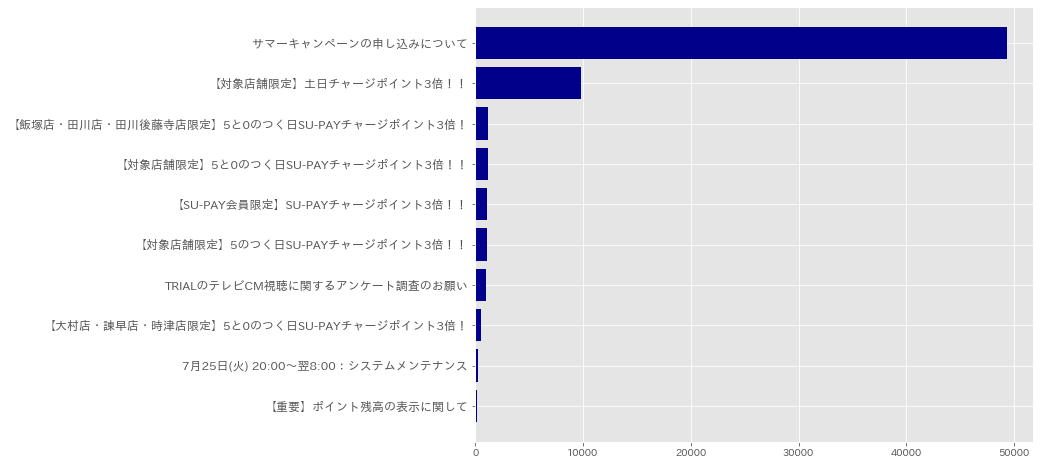

In [39]:
tmp = df_osirase[["user_id","result"]].drop_duplicates().groupby(["result"]).agg({"user_id":"count"}).sort_values("user_id",ascending=False).reset_index().head(10)
tmp = tmp.sort_values("user_id")
plt.figure(figsize=(10,8))
plt.barh(tmp["result"],tmp["user_id"], color="darkblue")
plt.yticks(fontsize=12)
plt.show()

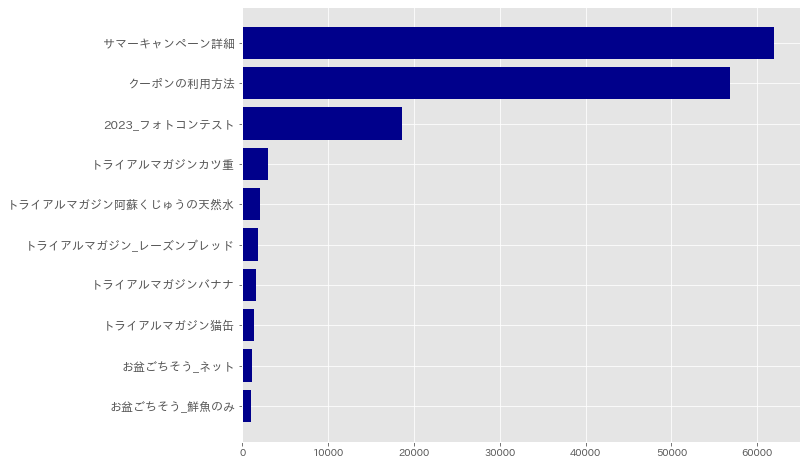

In [40]:
tmp = df_koukoku[["user_id","result"]].drop_duplicates().groupby(["result"]).agg({"user_id":"count"}).sort_values("user_id",ascending=False).reset_index().head(10)
tmp = tmp.sort_values("user_id")
plt.figure(figsize=(10,8))
plt.barh(tmp["result"],tmp["user_id"], color="darkblue")
plt.yticks(fontsize=12)
plt.show()

In [70]:
plot_tmp

user_id
salesday   result                      
2023-08-01 2023_フォトコンテスト            344
           お盆ごちそう_ネット               183
           お盆ごちそう_両方惣菜               57
           お盆ごちそう_両方鮮魚               59
           お盆ごちそう_惣菜のみ               16
...                                 ...
2023-08-28 トライアルマガジン_3種のスイーツ         49
           トライアルマガジン_ビール飲み比べ          5
           トライアルマガジン_レーズンブレッド        14
           トライアルマガジンカツ重              18
           トライアルマガジン阿蘇くじゅうの天然水       13

[290 rows x 1 columns]

In [75]:
plot_tmp["result"].unique()

array(['2023_フォトコンテスト', 'お盆ごちそう_ネット', 'お盆ごちそう_両方惣菜', 'お盆ごちそう_両方鮮魚',
       'お盆ごちそう_惣菜のみ', 'お盆ごちそう_鮮魚のみ', 'クーポンの利用方法', 'サマーキャンペーン詳細',
       'トライアルマガジンカツ重', 'トライアルマガジンバナナ', 'トライアルマガジン猫缶',
       'トライアルマガジン阿蘇くじゅうの天然水', 'トライアル会員限定\u3000虎の湯', 'アイランドシティ店チラシ',
       'アンケート', '宮若食事クーポン割引', 'EC_炭酸水', 'トライアルマガジン_レーズンブレッド',
       'フリースアンバサダー募集', 'TEST', '【テスト配信】初回200ポイントキャンペーン',
       '【テスト配信】初回200ポイント施策', '【テスト】DeepLink',
       '【大村店・諫早店・時津店限定】5と0のつく日SU-PAYチャージポイント3倍！！', 'トライアルマガジン_3種のスイーツ',
       'トライアルマガジン_ビール飲み比べ'], dtype=object)

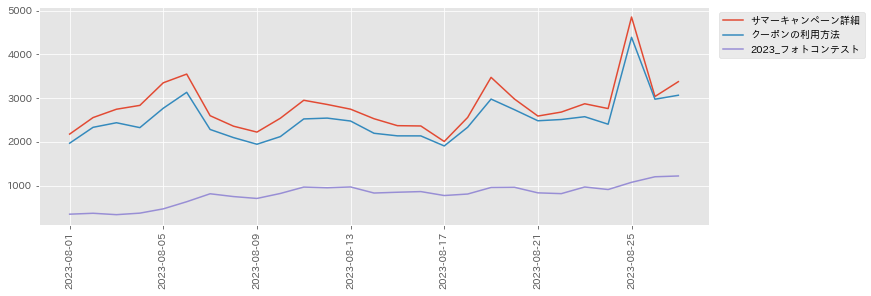

In [76]:
plot_tmp = df_koukoku[["salesday","user_id","result"]].drop_duplicates().groupby(["salesday","result"]).agg({"user_id":"count"}).reset_index()\
.query("salesday<=20230827")
plt.figure(figsize=(12,4))

plt.plot(plot_tmp.query("result=='サマーキャンペーン詳細'")["salesday"],plot_tmp.query("result=='サマーキャンペーン詳細'")["user_id"],label="サマーキャンペーン詳細")
plt.plot(plot_tmp.query("result=='クーポンの利用方法'")["salesday"],plot_tmp.query("result=='クーポンの利用方法'")["user_id"],label="クーポンの利用方法")
plt.plot(plot_tmp.query("result=='2023_フォトコンテスト'")["salesday"],plot_tmp.query("result=='2023_フォトコンテスト'")["user_id"],label="2023_フォトコンテスト")

plt.legend(loc="upper right", bbox_to_anchor=(1.24, 1))
plt.xticks(rotation=90)
plt.show()

In [80]:
df_koukoku[["result","user_id"]].drop_duplicates().groupby(["result"]).agg({"user_id":"count"}).sort_values("user_id",ascending=False)

,user_id
result,
サマーキャンペーン詳細,61896
クーポンの利用方法,56772
2023_フォトコンテスト,18570
トライアルマガジンカツ重,3016
トライアルマガジン阿蘇くじゅうの天然水,2100
トライアルマガジン_レーズンブレッド,1838
トライアルマガジンバナナ,1620
トライアルマガジン猫缶,1317
お盆ごちそう_ネット,1199


In [41]:
## ヘビーな顧客って色々と見ているとかある？
## ライトな顧客ほど会員カードとしてしか使っていなさそう。。

In [42]:
df_data

,salesday,user_id,ホーム閲覧数,ホーム閲覧来店回数,お知らせ閲覧数,広告閲覧数,クーポン閲覧数
0,2023-08-01,2970000000370,1.0,0.0,0.0,0.0,14.0
1,2023-08-01,2970000000431,1.0,0.0,0.0,0.0,0.0
2,2023-08-01,2970000000448,1.0,0.0,0.0,4.0,1.0
3,2023-08-01,2970000000493,1.0,1.0,0.0,0.0,1.0
4,2023-08-01,2970000000578,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1800444,2023-08-27,2970008916550,0.0,0.0,0.0,0.0,1.0
1800445,2023-08-27,2970008917441,0.0,0.0,0.0,0.0,2.0
1800446,2023-08-27,2970008917564,0.0,0.0,0.0,0.0,2.0
1800447,2023-08-27,2970008917991,0.0,0.0,0.0,0.0,2.0


In [43]:
df_home

,salesday_ure,user_id_ure,raiten_flg,view_name
6797636,2023-08-12,2900000089723,1,no
4529344,2023-08-09,2906800126156,1,no
2068934,2023-08-09,2960000000067,1,no
4235135,2023-08-05,2960000000135,1,no
8249844,2023-08-12,2960000000135,1,no
...,...,...,...,...
4458546,2023-08-08,2980001476562,1,no
8986309,2023-08-14,2980001476562,1,no
3803547,2023-08-07,2980001476562,1,no
5656154,2023-08-11,2980001476579,1,no


In [44]:
df_sale["salestime"] = pd.to_datetime(df_sale["salestime"])
df_sale["user_id"] = df_sale["user_id"].astype(str)
df_koukoku["salestime"] = pd.to_datetime(df_koukoku["sync_date"]).dt.tz_convert('Asia/Tokyo')

In [45]:
df_sale["salesday"] = pd.to_datetime(df_sale["salesday"])
df_koukoku["salesday"] = pd.to_datetime(df_koukoku["salesday"])
df_koukoku["salesday"] = df_koukoku["salesday"].dt.strftime("%Y-%m-%d")
df_koukoku["salesday"] = pd.to_datetime(df_koukoku["salesday"])

In [46]:
df_koukoku = df_koukoku[["user_id","result","salesday","salestime"]].rename(columns={"salestime":"koukoku_time"})
df_sale = df_sale[["salesday","salestime","user_id"]].rename(columns={"salestime":"sales_time"})

In [47]:
df_tmp = df_sale.merge(df_koukoku,on=["user_id","salesday"])

In [48]:
# df_tmp["sales_time"] - df_tmp["koukoku_time"]

### 渡部さんからの確認依頼

In [49]:
# # 広告viewをタップ
# query = """
# SELECT * 
# FROM `inunaki.dwd_log_0001.dwd_actionlog_ssc` 
# WHERE operationDay = "2023-08-01"
# """
# #データフレームに変換
# df_ccs = client.query(query).to_dataframe()

In [50]:
# df_ccs.head()

In [51]:
# df_ccs["operationName"].unique()

In [52]:
# df_ccs["storeCode"].nunique()

In [53]:
# df_ccs.query("operationName=='クーポンポップ'")["storeCode"].nunique()

In [54]:
# df_ccs.query("operationName=='クーポンポップ'")

In [55]:
# df_ccs.query("cardNo=='e94415918133c27845a246a9470929b8'").sort_values("operationTime")[23:]

In [56]:
# df_ccs.query("operationName=='クーポン利用'")["storeCode"].nunique()

In [57]:
# df_ccs.query("operationName=='クーポンポップ'")["storeCode"].unique()

In [58]:
# a = df_ccs[["storeCode"]].drop_duplicates().sort_values("storeCode")
# a["flg"] = 1
# b = df_ccs.query("operationName=='クーポンポップ'")[["storeCode"]].drop_duplicates().sort_values("storeCode")
# b["b_flg"] = 1
# ab = a.merge(b,on="storeCode",how="outer").fillna(0)

In [59]:
# ab.query("b_flg==0")

In [60]:
# df_tmp = df_ccs.query("storeCode==284")
# df_tmp[df_tmp["operationName"].str.contains("クーポン")]["operationName"].unique()

In [61]:
# df_tmp.query("operationName=='クーポン利用'")

In [62]:
# df_ccs.query("cCouponId=='64b119344475f05dd80bc382'")

In [63]:
# df_tmp.query("cardNo=='16ebc1d46bc0abed8505e54f359df84e'").sort_values("operationTime")[23:]

In [64]:
# df_ccs["operationName"].value_counts().reset_index().head(20)